In [1]:
### Loading IMAGE and MASK data into python lists ###

import os
target_dir = "/home/studio-lab-user/my-datasets/FloodNet Challenge @ EARTHVISION 2021 - Track 1/Train/Labeled"
image_dir = "/home/studio-lab-user/my-datasets/FloodNet Challenge @ EARTHVISION 2021 - Track 1/Train/Classification"
CATEGORIES = ["Flooded", "Non-Flooded"]

mask_paths = sorted(
    [
        os.path.join(target_dir, category, "mask", mask_name)
        for category in CATEGORIES
        for mask_name in os.listdir(os.path.join(target_dir, category, "mask"))
        if mask_name.endswith(".png")
    ]
)

image_paths = []
for path in mask_paths:
    if(path.find("Non-Flooded") != -1): # Check if "Non-FLooded" is present in path
        temp = target_dir + "/" + CATEGORIES[1] + "/mask/"
        im_path = path[len(temp):-8]+".jpg"
        full_path = os.path.join(image_dir, CATEGORIES[1], im_path)
    else: # Otherwise 
        temp = target_dir + "/" + CATEGORIES[0] + "/mask/"
        im_path = path[len(temp):-8] + ".jpg"
        full_path = os.path.join(image_dir, CATEGORIES[0], im_path)             
    image_paths.append(full_path)

In [2]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

'''
Helper class to load data in batches. Uses keras.utils.Sequence. 
Refer https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
'''

class FloodNetDataLoader(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, image_paths, mask_paths, img_channels=3):
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_channels = img_channels
        self.image_paths = image_paths
        self.mask_paths = mask_paths
    
    def __len__(self, ):
        return len(self.image_paths)//self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i:i+self.batch_size]
        batch_mask_paths = self.mask_paths[i:i+self.batch_size]
        
        X = np.zeros((self.batch_size,) + self.img_size + (self.img_channels,), dtype="float32")
        for n, path in enumerate(batch_image_paths):
            img = load_img(path=path, target_size=self.img_size)
            X[n] = img
        
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for n, path in enumerate(batch_mask_paths):
            mask = load_img(path=path, target_size=self.img_size, color_mode="grayscale")
            y[n] = np.expand_dims(mask, axis=2) # converts (height, width) -> (height, width, 1) to add one channel as grayscale
            
        return X, y

In [3]:
### Spliting data into Train set and Validation set ###

import random 

random.Random(454).shuffle(image_paths)
random.Random(454).shuffle(mask_paths)

val_samples = 65 # number of data samples being set aside for validation

train_set_images = image_paths[:-val_samples] 
train_set_masks = mask_paths[:-val_samples]
test_set_images = image_paths[-val_samples:]
test_set_masks = mask_paths[-val_samples:]

### Loading the data ###

IMG_SIZE = (240, 320)
train_set = FloodNetDataLoader(
    batch_size=8, img_size=IMG_SIZE, image_paths=train_set_images, mask_paths=train_set_masks
)
test_set = FloodNetDataLoader(
    batch_size=8, img_size=IMG_SIZE, image_paths=test_set_images, mask_paths=test_set_masks
)

In [ ]:
from unet_xception_model import get_model

IMG_SIZE = (240, 320)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session() 

my_model = get_model(img_size=IMG_SIZE, in_channels=3, classes=10)
my_model.summary()

In [ ]:
my_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = "archive/UNET_X/UNET_X_floodnet.ckpt"

callbacks_list = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True
    ),
]

my_model.load_weights(checkpoint_path)

my_model.fit(
    x=train_set,
    epochs=1,
    validation_data=test_set,
    callbacks=callbacks_list
)

In [4]:
from unet_xception_model import get_model
new_model = get_model(img_size=(240, 320), in_channels=3, classes=10)

checkpoint_path = "archive/UNET_X/UNET_X_floodnet.ckpt"
new_model.load_weights(checkpoint_path)

In [5]:
'''
Model.predict can also take in a numpy array of dimentions (batch_size, height, width, in_channels)
'''
preds = new_model.predict(test_set)

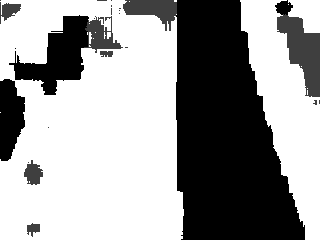

In [7]:
### display mask predictions ###
from Utils import display_mask_predictions
display_mask_predictions(preds[10])
print("")

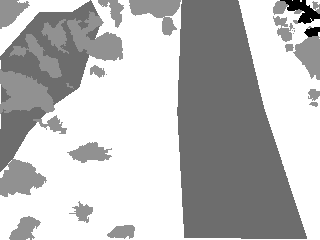

In [7]:
### display true masks ###
from Utils import display_mask
from tensorflow.keras.utils import load_img

img_arr = load_img(test_set_masks[10], color_mode="grayscale", target_size=(240, 320))
img_arr = np.array(img_arr)

display_mask(img_arr)
print("")

100%|██████████| 240/240 [00:00<00:00, 1490.21it/s]


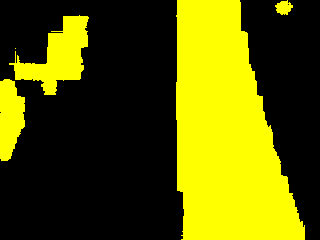

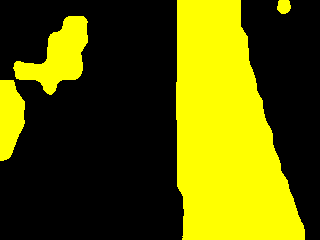

In [7]:
### display highlighted labels ###
from Utils import highlight_labels
im = highlight_labels(preds[10], 5, save_img=True)  
im.show()

### Smooth edges of the image ###
from PIL import ImageFilter
image = im.filter(ImageFilter.ModeFilter(size=10))
image.show()

(240, 320, 3)


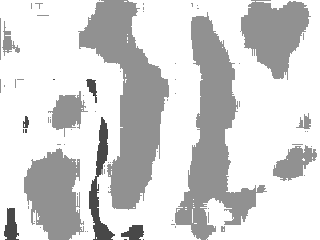

100%|██████████| 240/240 [00:00<00:00, 1527.95it/s]


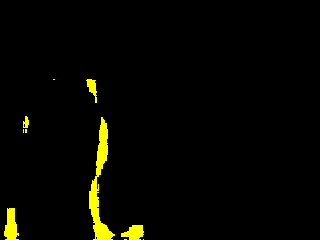

In [12]:
### display masks and highlighted labels from path ###
from tensorflow.keras.utils import load_img
path = "12.jpg"
test_img = load_img(path, target_size=(240, 320))
test_arr = np.array(test_img)
print(test_arr.shape)
test_arr = np.expand_dims(test_arr, axis=0)

pred_mask = new_model.predict(x=test_arr)
pred_mask = np.reshape(pred_mask, (240, 320, -1))

from Utils import display_mask_predictions, highlight_labels 
display_mask_predictions(pred_mask)
highlight_labels(pred_mask, 4)